In [1]:
import pandas as pd
import numpy as np

In [2]:
url = 'https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Dockless_Vehicle_Trips.csv'
data = pd.read_csv(url)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,ID,Device ID,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Modified Date,Month,Hour,Day of Week,Council District (Start),Council District (End),Origin Cell ID,Destination Cell ID,Year,Start Latitude,Start Longitude,End Latitude,End Longitude
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,scooter,358.0,915.0,06/29/2018 05:30:00 PM,06/29/2018 05:30:00 PM,12/12/2018 09:36:14 PM,6.0,17.0,5.0,5.0,9.0,013445,013916,2018.0,30.263,-97.762,30.259,-97.754
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,scooter,226.0,839.0,11/30/2018 11:00:00 AM,11/30/2018 11:00:00 AM,12/13/2018 03:43:44 PM,11.0,11.0,5.0,9.0,9.0,014556,015186,2018.0,30.283,-97.745,30.284,-97.737
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,scooter,324.0,1206.0,10/02/2018 03:15:00 PM,10/02/2018 03:30:00 PM,12/13/2018 03:49:54 PM,10.0,15.0,2.0,9.0,9.0,015344,015032,2018.0,30.285,-97.734,30.291,-97.738
3,0000261e-c0f0-4fb1-9947-1606dfe4ddcf,41fa0cf0-f433-4b3a-89f5-2c6cec6c367d,scooter,1096.0,0.0,09/02/2018 04:45:00 PM,09/02/2018 05:00:00 PM,12/13/2018 03:53:09 PM,9.0,16.0,0.0,9.0,9.0,014707,014081,2018.0,30.268,-97.743,30.276,-97.752
4,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,scooter,408.0,1144.0,09/28/2018 11:45:00 AM,09/28/2018 11:45:00 AM,12/12/2018 10:24:56 PM,9.0,11.0,5.0,3.0,3.0,016114,015642,2018.0,30.242,-97.721,30.244,-97.729


In [4]:
# save dataset locally to the folder 
# data.to_csv('austin_dockless.csv')

In [9]:
# check datatypes 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746505 entries, 0 to 2746504
Data columns (total 20 columns):
ID                          object
Device ID                   object
Vehicle Type                object
Trip Duration               float64
Trip Distance               float64
Start Time                  object
End Time                    object
Modified Date               object
Month                       float64
Hour                        float64
Day of Week                 float64
Council District (Start)    float64
Council District (End)      float64
Origin Cell ID              object
Destination Cell ID         object
Year                        float64
Start Latitude              float64
Start Longitude             float64
End Latitude                float64
End Longitude               float64
dtypes: float64(12), object(8)
memory usage: 419.1+ MB


We need to convert 'Start Time' and 'End Time' column types to datettime format

In [12]:
data['Start Time'] = pd.to_datetime(data['Start Time'], infer_datetime_format=True)

In [14]:
data['End Time'] = pd.to_datetime(data['End Time'], infer_datetime_format=True)

From https://chih-ling-hsu.github.io/2018/01/02/clustering-python

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from geopy.distance import vincenty
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# from mpl_toolkits.basemap import Basemap
import copy
import json
import math
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd

%matplotlib inline

In [71]:
file_location = 'Dockless_data_Austin.csv'
df_loc = pd.read_csv(file_location, nrows=1000000)

In [21]:
geolink = 'Council Districts Fill.geojson'
geo = gpd.GeoDataFrame.from_file(geolink)

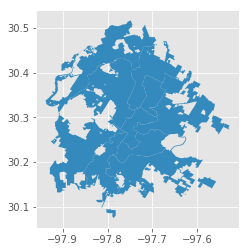

In [23]:
geo.plot();

In [5]:
#df_loc = df_loc.head(1000)

In [7]:
df_loc.columns

Index(['id', 'device_id', 'vehicle_type', 'trip_duration', 'trip_distance',
       'start_time', 'end_time', 'modified_date', 'month', 'hour',
       'day_of_week', 'council_district_start', 'council_district_end',
       'origin_cell_id', 'destination_cell_id', 'year', 'start_latitude',
       'start_longitude', 'end_latitude', 'end_longitude'],
      dtype='object')

## Spatial Clustering

Using stations’ geo-information to do clustering

In [72]:
X = df_loc[['start_latitude', 'start_longitude']].values

### K-Means

In [73]:
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

#### Elbow Method

The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset. This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn’t give much better modeling of the data.
Percentage of variance explained is the ratio of the between-group variance to the total variance.

In [74]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

MemoryError: 

In [79]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


In [80]:
centers = kmeans.cluster_centers_


In [81]:
plt.scatter

<function matplotlib.pyplot.scatter>

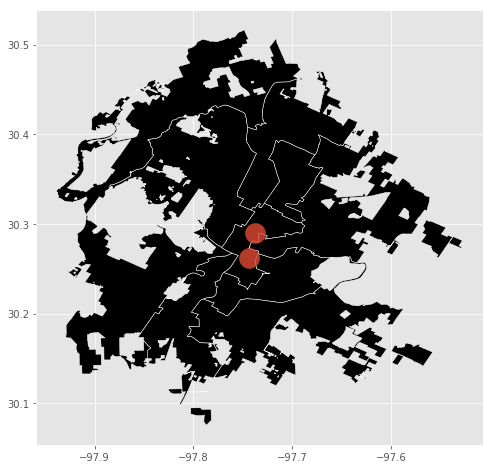

In [82]:
fig, ax = plt.subplots(1, figsize=(8,8))
geo.plot(ax=ax, color='black', edgecolor='white')
plt.scatter(centers[:, 1], centers[:, 0], s=400, alpha=0.8)

In [83]:
!ls

Council Districts Fill.geojson	Dockless_data_Austin.csv
Council Districts Fill.zip	dockless_scooters.ipynb


In [85]:
scooters = pd.read_csv('Dockless_data_Austin.csv')

In [86]:
scooters.columns

Index(['id', 'device_id', 'vehicle_type', 'trip_duration', 'trip_distance',
       'start_time', 'end_time', 'modified_date', 'month', 'hour',
       'day_of_week', 'council_district_start', 'council_district_end',
       'origin_cell_id', 'destination_cell_id', 'year', 'start_latitude',
       'start_longitude', 'end_latitude', 'end_longitude'],
      dtype='object')

In [89]:
scooters.device_id.nunique()

26096

In [99]:
ride_per_device = scooters[['device_id', 'id']].groupby('device_id').count('id')

TypeError: count() takes 1 positional argument but 2 were given

In [110]:
ride_per_device.head()

,id
device_id,
00066528-4d85-4cc8-bacf-a904f3ec96d8,234
001302a8-573f-4305-98e2-2f719eb0d840,87
0016d2fd-6dec-4fd5-8834-e21cbcd98eac,172
00197264-a88c-4c8f-9f19-efe6c2c25dfb,25
0019f934-1dfb-4225-be32-1a6b647c6efc,90


In [112]:
ride_per_device.reset_index(inplace=True)

In [114]:
ride_per_device = ride_per_device.rename(columns={'id':'number_of_rides'})

In [116]:
ride_per_device.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26096 entries, 0 to 26095
Data columns (total 2 columns):
device_id          26096 non-null object
number_of_rides    26096 non-null int64
dtypes: int64(1), object(1)
memory usage: 407.8+ KB


In [142]:
ride_per_device[ride_per_device['number_of_rides'] < 50]

,device_id,number_of_rides
3,00197264-a88c-4c8f-9f19-efe6c2c25dfb,25
14,00387fab-9fa4-439b-99f6-179c71f38326,21
15,0044a782-a09f-41ed-b07d-f73a6c033b52,2
20,005b8a5c-c5f3-4b8d-8d94-69f4161c5835,16
26,0068633b-943c-436e-9d73-4cbfd037a0f6,16
27,00774896-d93b-40db-bee8-9bdb331b4afd,41
31,0089793f-e637-4f80-84aa-3e22927f2a7e,21
32,00899b2f-ff0b-490e-beb8-cb0a4884ac4e,1
33,008a542b-5734-4ab3-bdea-4c0e5d81eacc,26
34,008b8abf-a663-4953-9234-7f816559a27c,41
